# TODO:

- loading and vrp gifs (later, not priority)
- joblib multiprocessing for all "for my_batch" loops?
- 

Notes:
- change state for final depot rotations (until all batches are done) to -1?
- store transitions via deepcopy
- compare the instances (n_vehicles, n_packages, n_dest) to Gendreau to pick similar vehicle packing levels?
- Alternatively train with a variety of packing levels (packages_perc_of_av_vol) -> closer to reality

In [1]:
import sys
sys.path.append('../src/')

import numpy as np
import random
import time
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from gym import Env
from gym.spaces import Discrete, Box

from my_helper_functions import hf
from env_funcs import Vehicle
from itertools import repeat
from envs.gendreau_parallel import TDCVRP as TDCVRP_par
from envs.gendreau import TDCVRP

from joblib import Parallel, delayed
from itertools import repeat

In [4]:
%%time

#%%prun # for profiling
np.random.seed(42)

# random agent testing
my_batch_size = 10

t = time.time()
env = TDCVRP_par(n_destinations=10, 
          packages_perc_of_av_vol=90,
          frag_freq_prob=25,
          test_set= 1,
          folder= "Test_folder",
          foldername= "Test_foldername",
          batch_size= my_batch_size,
         )



#env.reset()

delta_t = np.round((time.time() - t))
print("Time to reset env: {} sec; {} sec per batch".format(delta_t, delta_t/env.batch_size))

episodes = 1

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 

    naive_action = 0
    done_iter = True
    counter = 0
    while done_iter:
        t = time.time()
        naive_action += 1

        
        actions = np.zeros([my_batch_size, 2])

        for i in range(env.batch_size):
            
            #env.mask[i][0] = 2 - (np.sum(env.mask[i])>1)*2 # discouraging going to the depot prematurely to get nicer plots
            #print("Mask Batch ", i, env.mask[i])
            # pick item
            enumerates = np.arange(env.mask.shape[1])
            logits = env.mask[i] / np.sum(env.mask[i])
            actions[i, 0] = np.random.choice(a=enumerates, replace=False, p=logits)

            # pick rotation
            item_feasibility = env.get_rot_feas(i, actions[i, 0])
            enumerates = np.arange(2)
            logits = item_feasibility / np.sum(item_feasibility)
            actions[i, 1] = np.random.choice(a=enumerates, replace=False, p=logits)
            actions = actions.astype(int)

        #print("Mask \n", env.mask)
        #print("Actions taken: ", actions)
        #print("Dest Mask: ", env.same_dest_mask)
        #print("Feas Mask \n", env.feasibility_mask)
        

        #actions = agent.compute_action(state)

        n_state, reward, done, info = env.step(actions)
        state = n_state
        score+=reward
        done_iter = not all(done)

        #print(env.pandas_state(0))
        #print(env.pandas_state(1))

        print("Time for step {} ({} 'parallel' instances, {} destinations, {} items): {} sec ({} sec per instance)".format(counter, env.batch_size, env.n_destinations,env.state.shape[1], np.round(time.time() - t, 2), np.round((time.time() - t)/env.batch_size, 3)))
        counter += 1
        #print("Rewards:", env.rewards)

    #print('Episode:{} Score:{}'.format(episode, score))

#print("Trajectory: \n", env.clean_trajectory)


Time to reset env: 2.0 sec; 0.2 sec per batch
Time for step 0 (10 'parallel' instances, 10 destinations, 22 items): 0.36 sec (0.036 sec per instance)
Time for step 1 (10 'parallel' instances, 10 destinations, 22 items): 1.08 sec (0.108 sec per instance)
Time for step 2 (10 'parallel' instances, 10 destinations, 22 items): 1.18 sec (0.118 sec per instance)
Time for step 3 (10 'parallel' instances, 10 destinations, 22 items): 2.06 sec (0.206 sec per instance)
Time for step 4 (10 'parallel' instances, 10 destinations, 22 items): 0.9 sec (0.09 sec per instance)
Time for step 5 (10 'parallel' instances, 10 destinations, 22 items): 0.73 sec (0.073 sec per instance)
Time for step 6 (10 'parallel' instances, 10 destinations, 22 items): 0.78 sec (0.078 sec per instance)
Time for step 7 (10 'parallel' instances, 10 destinations, 22 items): 0.53 sec (0.053 sec per instance)
Time for step 8 (10 'parallel' instances, 10 destinations, 22 items): 0.22 sec (0.022 sec per instance)
Time for step 9 (10 

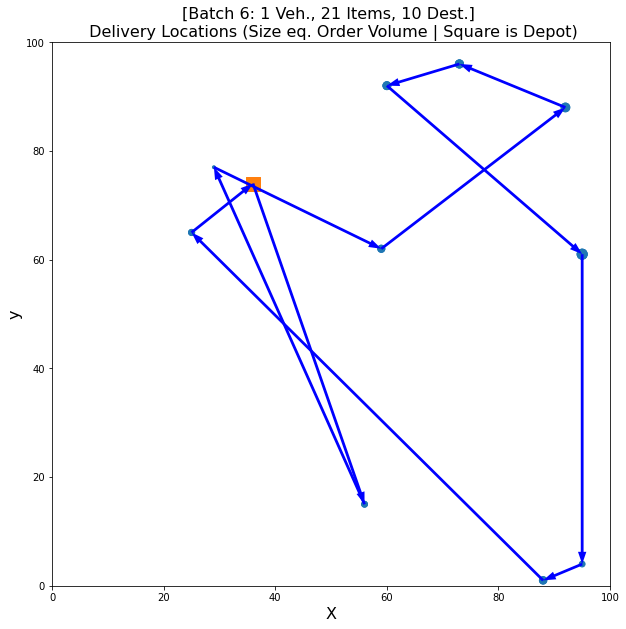

../src/envs/gendreau_parallel.py:1007: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


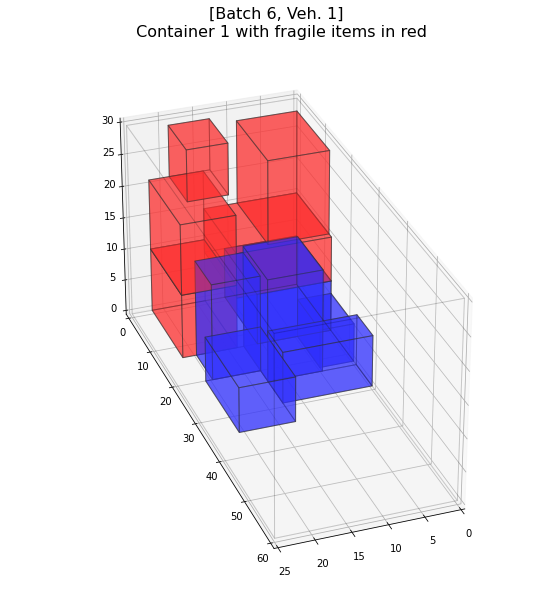

,dest,x,y,h,w,l,frag,pos_h,pos_w,pos_l,pos_h_r,pos_w_r,pos_l_r,rot,d_prev,n_veh,seq_nr,l_skip,l_skip_r,feas,feas_r
0,0,36,74,0,0,0,0,-1,-1,-1,-1,-1,-1,0,0,1,12,0,0,0,0
1,1,25,65,8,5,11,0,0,0,0,0,0,0,0,142,0,0,0,0,0,0
2,1,25,65,8,14,11,0,0,0,0,0,0,0,1,142,1,1,0,0,0,0
3,2,56,15,7,14,8,0,0,0,30,0,13,21,1,622,1,11,30,21,0,0
4,2,56,15,15,7,7,0,0,13,14,0,13,14,0,622,1,10,14,14,0,0
5,3,95,61,13,11,6,0,0,14,0,0,14,0,0,604,0,0,0,0,0,0
6,3,95,61,10,14,8,1,0,0,14,0,14,0,1,604,1,4,0,0,0,0
7,3,95,61,16,13,12,0,0,0,14,0,0,14,0,604,0,0,14,14,0,0
8,4,59,62,16,13,5,0,8,0,24,0,13,14,0,259,0,0,24,13,0,0
9,4,59,62,11,8,14,1,10,14,0,0,0,30,0,259,1,8,0,30,0,0


In [5]:
longest_random_run = np.argmax(np.sum(env.clean_trajectory > 0, axis = 1))
env.disp_batch(batch = longest_random_run, truck = 0)

In [6]:
#env.make_gif(batch=longest_random_run, my_title="random_agent")

In [7]:
env.clean_trajectory

array([[ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  8,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  2, 10,  3,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  1,  3,  8,  7, 10,  2,  0,  0,  0,  0,  0],
       [ 0,  8,  7,  5,  9,  1,  3, 10,  4,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 10,  6,  3,  5,  8,  7,  4,  9,  2,  2,  0],
       [ 0,  1,  8,  3,  5,  6,  2,  7, 10,  4,  0,  0,  0],
       [ 0,  1,  4,  3,  8,  6,  9,  5,  0,  0,  0,  0,  0],
       [ 0,  8,  1,  4,  6, 10,  0,  0,  0,  0,  0,  0,  0]])